In [1]:
CODE_PATH = '../../code/'
UKBB_DATA_PATH = '../../data/ukbb/'
BASE_LOG_PATH = '../../models/ukbb/SVIExperiment/'

# Setup

In [2]:
%matplotlib inline
import sys
import os

sys.path.append(CODE_PATH)

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import torch
import pyro
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import inspect
from collections import OrderedDict
from functools import partial
import torch

from tqdm import tqdm, trange

import traceback
import warnings
from scipy.stats import gaussian_kde

warnings.filterwarnings("ignore", category=UserWarning)

torch.autograd.set_grad_enabled(False);

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmaps = [cm.Reds, cm.Blues, cm.Greens]
img_cm = 'Greys_r'
diff_cm = 'seismic'

In [4]:
from datasets.medical.ukbb import UKBBDataset

data_dir = f'{UKBB_DATA_PATH}/test.csv'
downsample = 3
ukbb_test = UKBBDataset(data_dir, crop_type='center', downsample=downsample)

In [5]:
from experiments.medical import ukbb  # noqa: F401
from experiments.medical.base_experiment import EXPERIMENT_REGISTRY, MODEL_REGISTRY

In [6]:
var_name = {'ventricle_volume': 'v', 'brain_volume': 'b', 'sex': 's', 'age': 'a'}
value_fmt = {
    'ventricle_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'brain_volume': lambda s: rf'{float(s)/1000:.4g}\,\mathrm{{ml}}',
    'age': lambda s: rf'{int(s):d}\,\mathrm{{y}}',
    'sex': lambda s: '{}'.format(['\mathrm{female}', '\mathrm{male}'][int(s)])
}

def fmt_intervention(intervention):
    if isinstance(intervention, str):
        var, value = intervention[3:-1].split('=')
        return f"$do({var_name[var]}={value_fmt[var](value)})$"
    else:
        all_interventions = ', '.join([f'{var_name[k]}={value_fmt[k](v)}' for k, v in intervention.items()])
        return f"$do({all_interventions})$"

def prep_data(batch):
    x = batch['image'].unsqueeze(0) * 255.
    age = batch['age'].unsqueeze(0).unsqueeze(0).float()
    sex = batch['sex'].unsqueeze(0).unsqueeze(0).float()
    ventricle_volume = batch['ventricle_volume'].unsqueeze(0).unsqueeze(0).float()
    brain_volume = batch['brain_volume'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()

    return {'x': x, 'age': age, 'sex': sex, 'ventricle_volume': ventricle_volume, 'brain_volume': brain_volume}

In [7]:
experiments = ['ConditionalVISEM']
models = {}
loaded_models = {}

for exp in experiments:
    try:
        checkpoint_path = f'{BASE_LOG_PATH}/{exp}/version_0/'

        base_path = os.path.join(checkpoint_path, 'checkpoints')
        checkpoint_path = os.path.join(base_path, os.listdir(base_path)[0])

        ckpt = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        hparams = ckpt['hparams']
        
        model_class = MODEL_REGISTRY[hparams['model']]

        model_params = {
            k: v for k, v in hparams.items() if (k in inspect.signature(model_class.__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__init__).parameters
                                                 or k in k in inspect.signature(model_class.__bases__[0].__bases__[0].__init__).parameters)
        }
        
        new_state_dict = OrderedDict()

        for key, value in ckpt['state_dict'].items():
            new_key = key.replace('pyro_model.', '')
            new_state_dict[new_key] = value
            
        loaded_model = model_class(**model_params)
        loaded_model.load_state_dict(new_state_dict)
        
        for p in loaded_model._buffers.keys():
            if 'norm' in p:
                setattr(loaded_model, p, getattr(loaded_model, p))
                
        loaded_model.eval()
                
                
        loaded_models[exp] = loaded_model
        
        def sample_pgm(num_samples, model):
            with pyro.plate('observations', num_samples):
                return model.pgm_model()
        
        models[exp] = partial(sample_pgm, model=loaded_model)
    except Exception as e:
        print(e)
        traceback.print_exc()

In [8]:
def plot_gen_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32):
    fig, ax = plt.subplots(3, len(interventions), figsize=(1.6 * len(interventions), 5), gridspec_kw=dict(wspace=0, hspace=0))
    lim = 0
    
    orig_data = prep_data(ukbb_test[idx])
    
    imgs = []
    for intervention in interventions:
        pyro.clear_param_store()
        cond = {k: torch.tensor([[v]]) for k, v in intervention.items()}
        counterfactual = loaded_models[model_name].counterfactual(orig_data, cond, num_samples)

        imgs += [counterfactual['x']]
        
        diff = (orig_data['x'] - imgs[-1]).squeeze()

        lim = np.maximum(lim, diff.abs().max())

    for i, intervention in enumerate(interventions):
        x = imgs[i]
        x_test = orig_data['x']
        diff = (x_test - x).squeeze()
        if not normalise_all:
            lim = diff.abs().max()

        ax[0, i].imshow(x_test.squeeze(), 'Greys_r', vmin=0, vmax=255)
        
        ax[0, i].set_title(fmt_intervention(intervention))
        ax[1, i].imshow(x.squeeze(), 'Greys_r', vmin=0, vmax=255)

        ax[2, i].imshow(diff, 'seismic', clim=[-lim, lim])

        for axi in ax[:, i]:
            axi.axis('off')
            axi.xaxis.set_major_locator(plt.NullLocator())
            axi.yaxis.set_major_locator(plt.NullLocator())
    
    suptitle = '$s={sex}; a={age}; b={brain_volume}; v={ventricle_volume}$'.format(
        **{att: value_fmt[att](orig_data[att].item()) for att in ('sex', 'age', 'brain_volume', 'ventricle_volume')}
    )
    fig.suptitle(suptitle, fontsize=14, y=1.02)
    
    fig.tight_layout()
    plt.show()

# Plotting

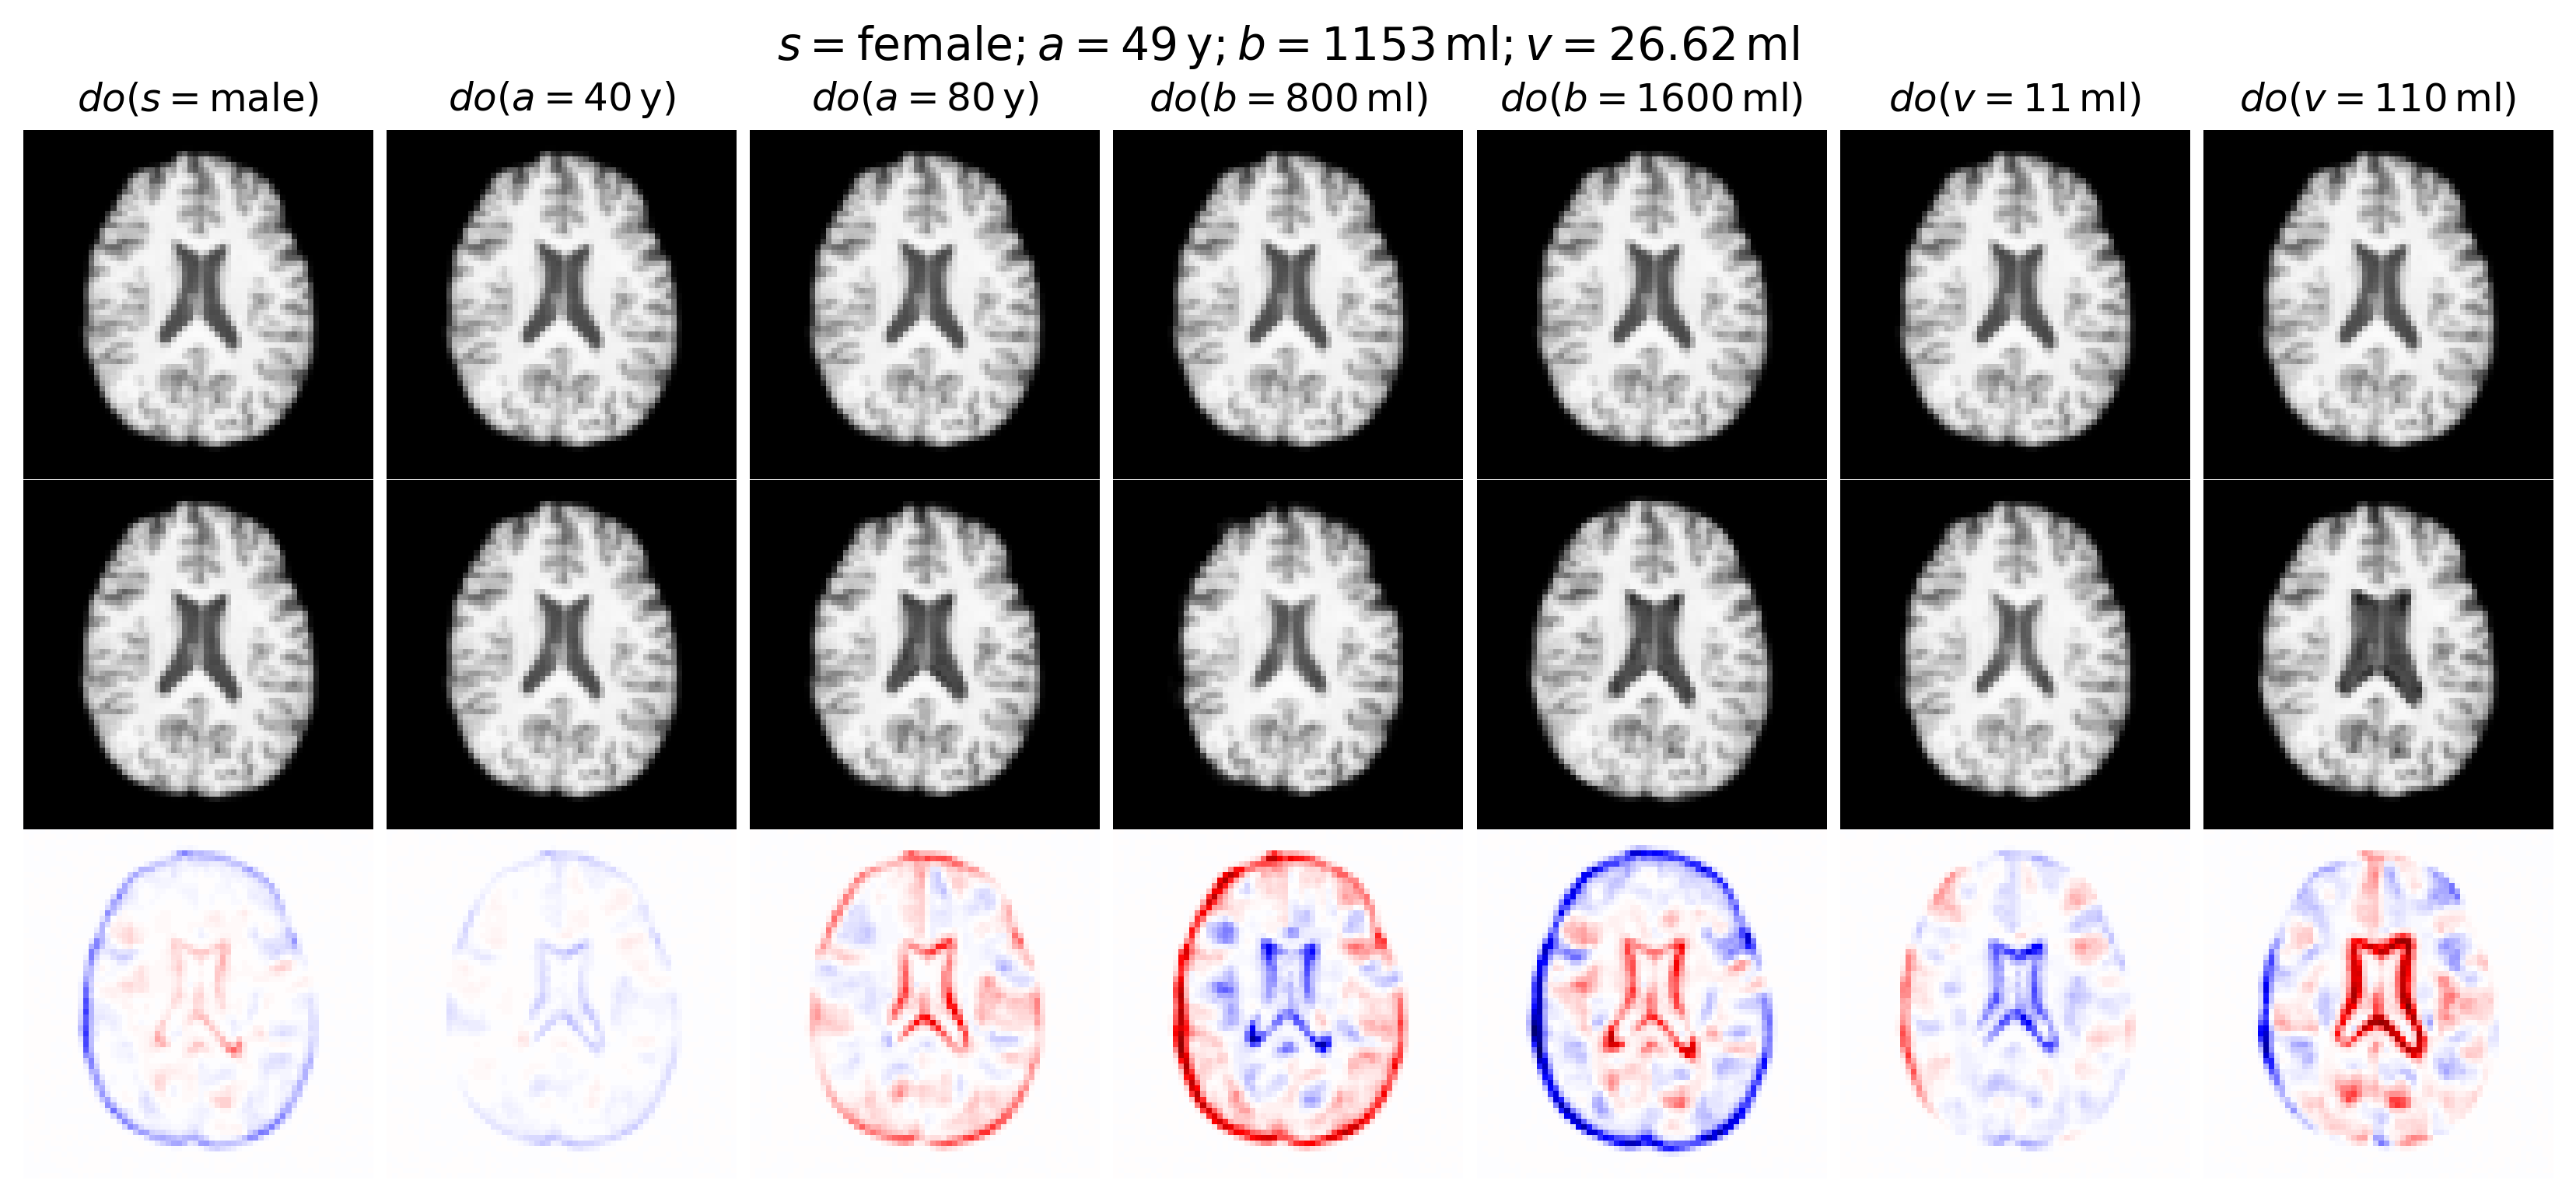

In [9]:
idx = 1337
model_name = 'ConditionalVISEM'

orig_data = prep_data(ukbb_test[idx])

interventions = [
    {'sex': 1.},
    {'age': 40.},
    {'age': 80.},
    {'brain_volume': 800000.},
    {'brain_volume': 1600000.},
    {'ventricle_volume': 11000.},
    {'ventricle_volume': 110000.},
]

plot_gen_intervention_range(model_name, interventions, idx, normalise_all=True, num_samples=32)